# Predicción de reservas de hoteles

En este notebook, exploraremos los modelos de clasificación del Spark MLlib. Clasificación es una tarea de predecir una clase, categoría o variable discreta dado un conjunto de variables de entrada. Se diferencia de la regresión en la que la variable de salida posee un número finito de valores posible.

## 1. Descripción del problema
Un gerente del banco está molesto porque cada vez más clientes abandonan sus servicios de tarjeta de crédito. Realmente apreciarían si se pudiera predecir quién va a ser expulsado para que puedan acudir de manera proactiva al cliente para brindarle mejores servicios y cambiar las decisiones de los clientes en la dirección opuesta.

In [1]:
# Filtrar los warning
import warnings
warnings.filterwarnings("ignore")

# Importar las librerías
import findspark
findspark.init('/usr/local/spark/') # Replazar la ruta al Apache Spark
from itertools import chain
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pandas as pd
from pyspark.sql import SparkSession

# Evitar el truncamiento de columnas de un Dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Iniciar SparkSession
spark = SparkSession \
        .builder \
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/09 21:44:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2. Sobre el conjunto de datos
El conjunto de datos consta de 10.000 clientes que mencionan su edad, salario, estado civil, límite de tarjeta de crédito, categoría de tarjeta de crédito, etc. Hay casi 18 características.

In [2]:
# Cargar el conjunto de datos
transactions = spark \
     .read \
     .option("header", "true") \
     .option("inferSchema", "true") \
     .csv("BankChurners.csv")

# Eliminar CLIENTNUM y las dos últimas columnas
transactions = transactions.drop("CLIENTNUM", transactions.columns[-1], transactions.columns[-2])

# Visualizar el conjunto de los datos
transactions.limit(10).toPandas()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


## 3. Transformación de los datos

Un aspecto fundamental del conjunto de datos es que aproximadamente un 16,07% del total de clientes ha abandonado el servicio de tarjeta. Por lo tanto, es necesario llevar en cuenta la falta de balance de los datos a la hora de evaluar la precisión de los modelos.

Para facilitar esta tarea, crearemos una nueva columna y asignaremos un peso a cada valor de la variable de salida, de tal manera que la clase minoritaria sea sobrerepresentada y tenga un peso mayor.

In [3]:
import numpy as np
from itertools import chain

# Computar los pesos
y_collect = transactions.select("Attrition_Flag").groupBy("Attrition_Flag").count().collect()
unique_y = [x["Attrition_Flag"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]
class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}

# Crear la nueva columna de pesos
mapping_expr = f.create_map([f.lit(x) for x in chain(*class_weights_spark.items())])
transactions = transactions.withColumn("weight", mapping_expr[f.col("Attrition_Flag")])

## 4. Definición de las etapas de procesamiento

El preprocesamiento de datos es el proceso de hacer que los datos crudos sean adecuados para un modelo de aprendizaje automático. Es el primer paso crucial al crear un modelo de aprendizaje.

Los pasos de preprocesamiento aplicados a nuestro conjunto de datos incluyeron:
* Codificación de las variables independientes categóricas ordinales mediante StringIndexer,
* Codificación de las variables independientes categóricas nominales mediante OneHotEncoder,
* Codificación de la variable dependiente mediante StringIndexer,
* Conversión de los datos de entrada a vectores densos mediante VectorAssembler, y
* Estandarización mediante el MinMaxScaler

In [4]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

# Definir las columnas de entrada y de salida
indexerInputCols = ['Education_Level', 'Income_Category', 'Card_Category']
indexerOutputCols=['Education_Level_cod', 'Income_Category_cod', 'Card_Category_cod']
indexerOneHotInputCols = ['Gender', 'Marital_Status']
oneHotInputCols = ['Gender_idx', 'Marital_Status_idx']
oneHotOutputCols = ['Gender_cod', 'Marital_Status_cod']
labelIndexerInputCol = "Attrition_Flag"
labelIndexerOutputCol = "label"
assemblerInputCols = ['Customer_Age','Gender_cod','Dependent_count','Education_Level_cod',
                      'Marital_Status_cod','Income_Category_cod','Card_Category_cod',
                      'Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon',
                      'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                      'Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt',
                      'Total_Trans_Ct']
assemblerOutputCol = "features_raw"
minmaxScalerInputCol = "features_raw"
minmaxScalerOutputCol = "features"

# Aplicar el StringIndexer a las variables categóricas ordinales
indexer = StringIndexer(inputCols=indexerInputCols, outputCols=indexerOutputCols, handleInvalid='keep', stringOrderType='frequencyDesc')

# Aplicar el OneHotEncoder a las variables categóricas nominales
indexerOneHot = StringIndexer(inputCols=indexerOneHotInputCols, outputCols=oneHotInputCols, handleInvalid='keep', stringOrderType='frequencyDesc')
onehot = OneHotEncoder(inputCols=oneHotInputCols, outputCols = oneHotOutputCols)

# Codificar variable de salida
labelIndexer = StringIndexer(inputCol=labelIndexerInputCol, outputCol=labelIndexerOutputCol, handleInvalid='error', stringOrderType='frequencyDesc')

# Aplicar el VectorAssembler
assembler = VectorAssembler(inputCols = assemblerInputCols, outputCol=assemblerOutputCol)

# Aplicar el MinMaxScaler para estandarizar los datos
minmaxscaler = MinMaxScaler(min=0.0, max=1.0, inputCol=minmaxScalerInputCol, outputCol=minmaxScalerOutputCol)

## 5. Evaluación dividida de train-test

Para evaluar nuestros modelos de aprendizaje automático, es necesario aplicar una técnica denominada evaluación dividida de **train-test**. Esta técnica consiste en separar el conjunto de datos en dos subconjuntos para que sean utilizados para diferentes propósitos:
* Uno de los subconjunto sería utilizado para entrenar el modelo, y
* El otro subconjunto sería utilizado para la evaluación del modelo.

El objetivo es estimar la performance del modelo de aprendizaje automático sobre datos nuevos (datos que no fueron utilizados para entrenar el modelo). Esta técnica es aplicable si tenemos un conjunto de datos lo suficientemente grande.

In [5]:
train, test = transactions.randomSplit([0.7, 0.3], seed=50)

## 6. Modelos de clasificación

### 6.1. Regresión logística

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Logistic Regression
lr = LogisticRegression(maxIter=100, regParam=0.0, elasticNetParam=0.0, threshold=0.5, 
                        family = "auto", weightCol="weight")

# Aplicar la pipeline de preprocesamiento
pipeline = Pipeline(stages=[indexer, indexerOneHot, onehot, labelIndexer, 
                            assembler, minmaxscaler, lr])
pipeline_fit = pipeline.fit(train)
predictions = pipeline_fit.transform(test).select("label", "features", "rawPrediction", "prediction")

# Visualizar el resultado de la transformación
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
print("La precisión del modelo es del {:0.2f}%".format(evaluator.evaluate(predictions)*100))

22/05/09 21:45:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


La precisión del modelo es del 91.37%


### 6.2. Árboles de decisión

In [7]:
from pyspark.ml.classification import DecisionTreeClassifier

# Árboles de decisión
dt = DecisionTreeClassifier(maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, 
                            maxMemoryInMB=256, checkpointInterval=10, weightCol="weight")

# Aplicar la pipeline de preprocesamiento
pipeline = Pipeline(stages=[indexer, indexerOneHot, onehot, labelIndexer, 
                            assembler, minmaxscaler, dt])
pipeline_fit = pipeline.fit(train)
predictions = pipeline_fit.transform(test).select("label", "features", "rawPrediction", "prediction")

# Visualizar el resultado de la transformación
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
print("La precisión del modelo es del {:0.2f}%".format(evaluator.evaluate(predictions)*100))

La precisión del modelo es del 91.13%


### 6.3. Random forest

In [8]:
from pyspark.ml.classification import RandomForestClassifier

# Random forest
rf = RandomForestClassifier(weightCol="weight")

# Aplicar la pipeline de preprocesamiento
pipeline = Pipeline(stages=[indexer, indexerOneHot, onehot, labelIndexer, 
                            assembler, minmaxscaler, rf])
pipeline_fit = pipeline.fit(train)
predictions = pipeline_fit.transform(test).select("label", "features", "rawPrediction", "prediction")

# Visualizar el resultado de la transformación
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
print("La precisión del modelo es del {:0.2f}%".format(evaluator.evaluate(predictions)*100))

La precisión del modelo es del 95.77%


### 6.4. Gradient-Boosted Decision Trees

In [9]:
from pyspark.ml.classification import GBTClassifier

# Gradient-boosted trees
gbt = GBTClassifier(stepSize=0.1, maxDepth=5, subsamplingRate=1.0, weightCol="weight")

# Aplicar la pipeline de preprocesamiento
pipeline = Pipeline(stages=[indexer, indexerOneHot, onehot, labelIndexer, 
                            assembler, minmaxscaler, gbt])
pipeline_fit = pipeline.fit(train)
predictions = pipeline_fit.transform(test).select("label", "features", "rawPrediction", "prediction")

# Visualizar el resultado de la transformación
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
print("La precisión del modelo es del {:0.2f}%".format(evaluator.evaluate(predictions)*100))

La precisión del modelo es del 97.55%


## 7. Optimización de modelos

### 7.1. Ajuste de hiperparámetros

Mientras que un algoritmo de aprendizaje automático intentar ajustar los **parámetros** para lograr aprender de los datos, los **hiperparámetros** son parámetros que no pueden ser ajustados por el modelo durante el entrenamiento. No obstante, estos hiperparámetros suelen estar relacionados a propiedades importantes de cada modelo y deben ser manualmente o automaticamente ajustados para obtener un modelo más preciso.

La mayoría de los hiperparámetros están relacionados:
- A los mecanismos de penalidad para prevenir sobreajuste o **overfitting** (por ejemplo, regularización L1 o L2),
- A la tasa de aprendizaje o learning rate, y
- Al tamaño del árbol en caso de modelos basados en árboles de decisión.

### 7.2. Validación cruzada (cross validation)
La validación cruzada es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. Consiste en calcular la media artimética obtenidas de las medidas de evaluación sobre diferentes particiones. 

La **validación cruzada de K iteracciones (K-fold cross-validation)** es la técnica más utilizada. Esta técnica divide un conjunto de datos en K subconjuntos. Uno de los subconjuntos se utiliza como datos de prueba y el resto (K-1) como datos de entrenamiento. El proceso de validación cruzada es repetido durante k iteracciones, con cada uno de los posibles subconjuntos de datos de prueba. Finalmente se realiza la media aritmética de los resultados de cada iteración para obtener un único resultado.

![k-fold](assets/3.jpg)

### 7.3. La curva ROC (Receiver Operating Characteristic)
La curva ROC es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario  según se varía el umbral de discriminación. En otras palabras, mide la proporción de la razón de verdaderos positivos (VPR) frente a la razón de falsos positivos (FPR) según varía el valor a partir del cual decidimos que un caso es positivo).

![ROC space](assets/1.png)

De la curva ROC se deriva el **Area Under the ROC Curve** o **AUC**. El AUC mide todo el área por debajo de la curva ROC, utilizando el cálculo integral. El valor de esta área puede variar del 0 al 1, y provee una medida de performance del modelo de clasificación.

![AUC space](assets/2.png)

### 7.4. Ejemplo de optimización

#### 7.4.1. Definir el modelo base

In [10]:
# Gradient-boosted trees
gbt = GBTClassifier(stepSize=0.1, maxDepth=5, maxBins=32, weightCol="weight")

#### 7.4.2. Definir el espacio de búsqueda con ParamGridBuilder

In [11]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.5, 1]) \
    .addGrid(gbt.maxBins, [2, 16, 32, 64, 128]) \
.build()

#### 7.4.3. Definir la pipeline

In [12]:
pipeline = Pipeline(stages=[indexer, indexerOneHot, onehot, labelIndexer, 
                            assembler, minmaxscaler, gbt])

#### 7.4.4. Definir el evaluador

In [13]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

#### 7.4.5. Definir nuestra validación cruzada

In [14]:
from pyspark.ml.tuning import CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # utilizar más de 3 folds en la práctica

#### 7.4.6. Entrenar el modelo

In [15]:
%%time
cvModel = crossval.fit(train)

CPU times: user 14.4 s, sys: 4.83 s, total: 19.2 s
Wall time: 10min 46s


#### 7.4.7. Ver los hiperparámetros de los 5 modelos con mejor precisión

In [16]:
model_params = pd.DataFrame([[i, z] for i, z in zip(cvModel.avgMetrics, paramGrid)], 
                            columns=["areaUnderROC", "params"]) \
                            .sort_values(by="areaUnderROC", ascending=False)
print(f"Se evaluó un total de {model_params.shape[0]} modelos")
model_params.head(5)

Se evaluó un total de 20 modelos


,areaUnderROC,params
14,0.982808,"{GBTClassifier_e9478c0370c5__stepSize: 0.5, GBTClassifier_e9478c0370c5__maxBins: 128}"
12,0.982546,"{GBTClassifier_e9478c0370c5__stepSize: 0.5, GBTClassifier_e9478c0370c5__maxBins: 32}"
13,0.981779,"{GBTClassifier_e9478c0370c5__stepSize: 0.5, GBTClassifier_e9478c0370c5__maxBins: 64}"
9,0.981075,"{GBTClassifier_e9478c0370c5__stepSize: 0.1, GBTClassifier_e9478c0370c5__maxBins: 128}"
8,0.980199,"{GBTClassifier_e9478c0370c5__stepSize: 0.1, GBTClassifier_e9478c0370c5__maxBins: 64}"


#### 7.4.8. Evaluar el mejor modelo sobre los datos de prueba

In [17]:
prediction = cvModel.transform(test)
print("La precisión del modelo es del {:0.2f}%".format(evaluator.evaluate(predictions)*100))

La precisión del modelo es del 97.55%


#### 7.4.9. Evaluar el mejor modelo mediante una matriz de confusión

La matriz de confusión es una técnica muy útil para evaluar el desempeño de un modelo de aprendizaje automático en un problema de clasificación binaria. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real.

Se le denomina **matriz de confusión** porque nos permite ver si el modelo está confundiendo las dos clases de la variable dependiente.

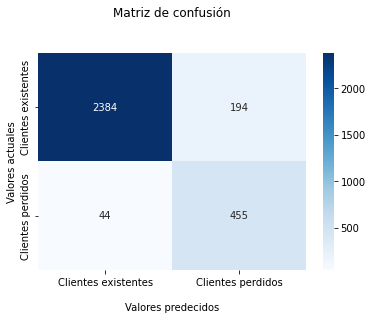

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Generar matriz de confusión
preds_and_labels = predictions.select(['prediction','label']) \
                              .withColumn('label1', f.col('label')\
                              .cast(FloatType())) \
                              .orderBy('prediction') \
                              .select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Generar gráfico
ax = sns.heatmap(metrics.confusionMatrix().toArray().astype('int64'), annot=True, cmap='Blues', fmt="d")
ax.set_title('Matriz de confusión\n\n');
ax.set_xlabel('\nValores predecidos')
ax.set_ylabel('Valores actuales');
ax.xaxis.set_ticklabels(['Clientes existentes','Clientes perdidos'])
ax.yaxis.set_ticklabels(['Clientes existentes','Clientes perdidos'])

## Mostrar el gráfico
plt.show()